In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow import data as tf_data
from keras import layers
import data_loader

In [2]:
# loading data
import data_loader
dataset = "/Users/nataliepegues/downloads/flower_dataset"

train_ds, val_ds = data_loader.load_and_prepare_dataset(
    dataset,
    image_size=(224, 224),
    batch_size=10,
    val_split=0.2,
    seed=1222
)

image_size = (224, 224)

Found 733 files belonging to 10 classes.
Using 587 files for training.
Using 146 files for validation.


2025-07-21 15:24:26.820358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


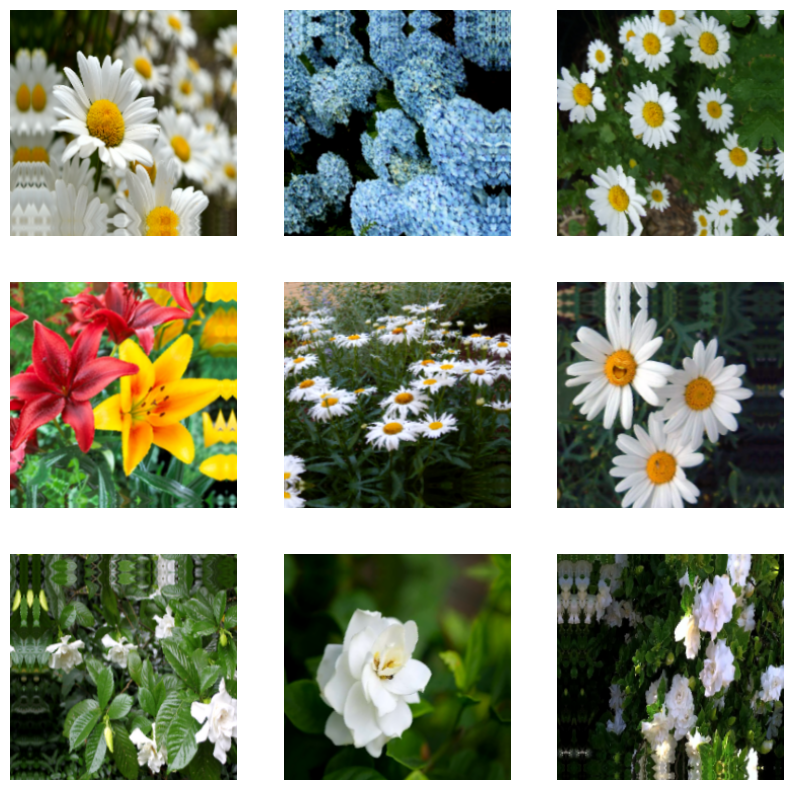

In [3]:
# using augmentation pipeline with 5 total augmentations
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1),
])

# augmenting training data only
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

# visualizing augmentations
plt.figure(figsize=(10, 10))
for images, labels in augmented_train_ds.take(2):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.axis("off")
plt.show()

In [4]:
# function to create ResNet50 model
def make_resnet50_model(input_shape, num_classes):
    backbone = keras.applications.ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    backbone.trainable = False  # freeze backbone

    inputs = layers.Input(input_shape)
    x = keras.applications.resnet.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    x = layers.GlobalAveragePooling2D()(x)

    units = 1 if num_classes == 2 else num_classes
    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(units, activation=None)(x)

    return keras.Model(inputs, outputs, name="resnet50_transfer")

image_size = (224, 224)
num_classes = 10

In [5]:
# creating model
model_resnet50 = make_resnet50_model(input_shape=image_size + (3,), num_classes=num_classes)

In [6]:
# training model
epochs = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model_resnet50.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

history = model_resnet50.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 356ms/step - acc: 0.1890 - loss: 2.5164 - val_acc: 0.6438 - val_loss: 1.1774
Epoch 2/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - acc: 0.6060 - loss: 1.1614 - val_acc: 0.8219 - val_loss: 0.6959
Epoch 3/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 22s 374ms/step - acc: 0.7808 - loss: 0.7683 - val_acc: 0.8630 - val_loss: 0.5188
Epoch 4/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 382ms/step - acc: 0.8650 - loss: 0.5159 - val_acc: 0.8767 - val_loss: 0.4183
Epoch 5/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 397ms/step - acc: 0.8808 - loss: 0.4156 - val_acc: 0.8904 - val_loss: 0.3715
Epoch 6/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 393ms/step - acc: 0.9103 - loss: 0.3484 - val_acc: 0.8973 - val_loss: 0.3359
Epoch 7/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 399ms/step - acc: 0.9312 - loss: 0.2916 - val_acc: 0.9041 - val_loss: 0.3089
Epoch 8/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 36s 602ms/step - acc: 0.9445 - loss: 0.2379 - val_acc: 0.9041 - val_loss: 0.2944


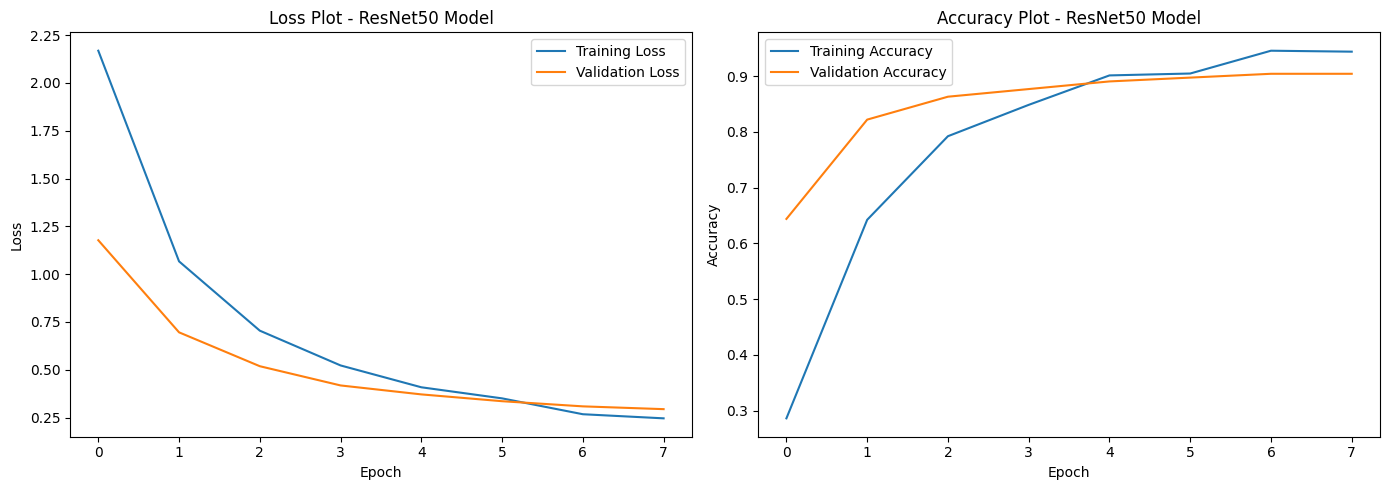

In [7]:
# plotting loss and accuracy
fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

axs[0].plot(history.history["loss"], label="Training Loss")
axs[0].plot(history.history["val_loss"], label="Validation Loss")
axs[0].set_title("Loss Plot - ResNet50 Model")
axs[0].legend()
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")

axs[1].plot(history.history["acc"], label="Training Accuracy")
axs[1].plot(history.history["val_acc"], label="Validation Accuracy")
axs[1].set_title("Accuracy Plot - ResNet50 Model")
axs[1].legend()
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

In [8]:
# saving model
model_resnet50.save("flowers_classifier_resnet50.keras")